Task 1: Import Libraries

In [0]:
from __future__ import print_function
%matplotlib inline
import os
import warnings
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as image
import pandas as pd
import pandas_profiling
from pandas_profiling import ProfileReport
plt.style.use("ggplot")
warnings.simplefilter("ignore")

In [0]:
plt.rcParams['figure.figsize']=(12,8)

Task 2: Exploratory Data Analysis

In [3]:
data=pd.read_csv("/content/turnover.csv")
data.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,work_accident,left,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [4]:
prof=pandas_profiling.ProfileReport(data,title="TurnOver Report")
prof

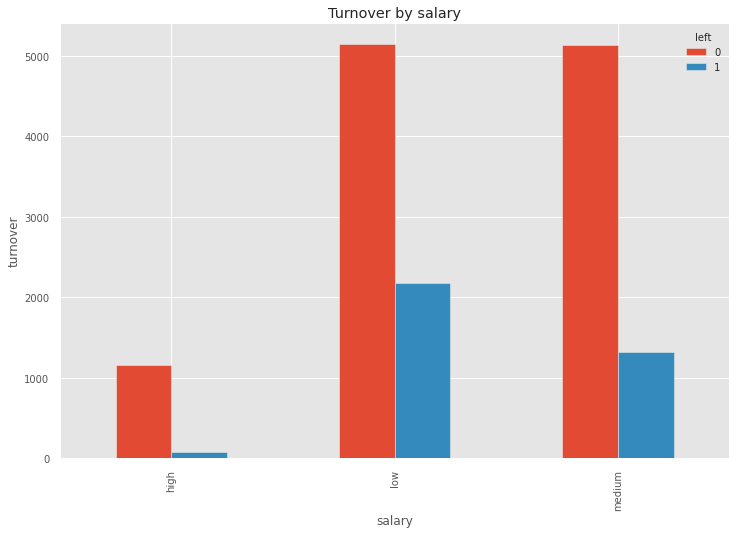

In [5]:
pd.crosstab(data.salary,data.left).plot(kind="bar")
plt.title("Turnover by salary")
plt.xlabel("salary")
plt.ylabel("turnover")
plt.show()

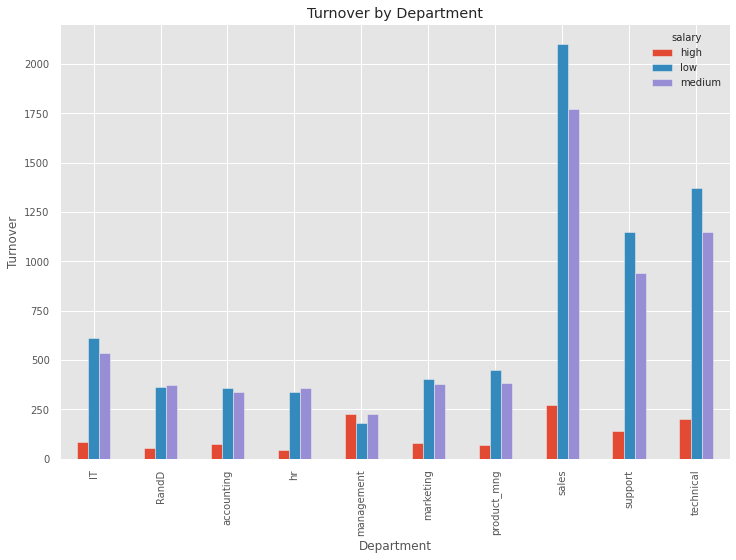

In [6]:
pd.crosstab(data.department,data.salary).plot(kind="bar")
plt.title("Turnover by Department")
plt.xlabel("Department")
plt.ylabel("Turnover")
plt.show()


Task 3: Encode Categorical Features

In [0]:
cat_vars=['department','salary']
for var in cat_vars:
  cat_list=pd.get_dummies(data[var],prefix=var)
  data=data.join(cat_list)

In [0]:
data.drop(columns=['department','salary'],axis=0,inplace=True)

In [9]:
data.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,work_accident,left,promotion_last_5years,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical,salary_high,salary_low,salary_medium
0,0.38,0.53,2,157,3,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0
1,0.80,0.86,5,262,6,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1
2,0.11,0.88,7,272,4,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1
3,0.72,0.87,5,223,5,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0
4,0.37,0.52,2,159,3,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0


Task 4: Visualize Class Imbalance

In [0]:
from yellowbrick.target import ClassBalance
plt.style.use("ggplot")
plt.rcParams['figure.figsize']=(12,8)

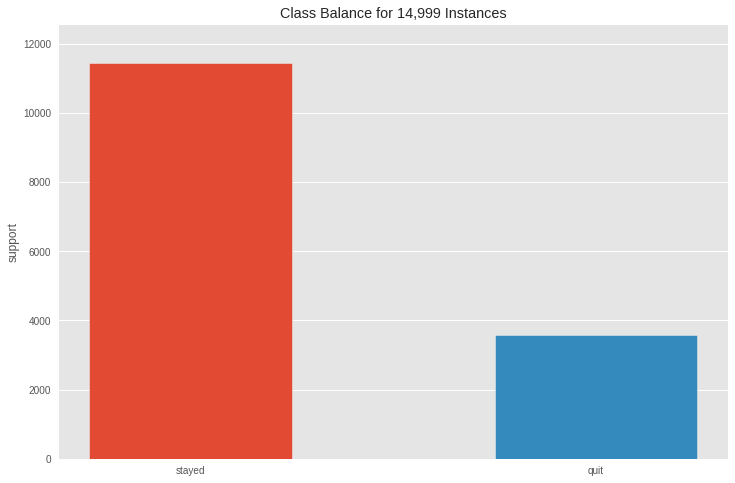

In [12]:
visualizer=ClassBalance(labels=['stayed','quit']).fit(data.left)
visualizer.show()

Task 5: Create Training and Test Sets

In [0]:
X=data.loc[:,data.columns!='left']
y=data.left

In [0]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=0,test_size=0.2,stratify=y)

Task 6: Build an Interactive Decision Tree Classifier

In [0]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import export_graphviz # display the tree within a Jupyter notebook
from IPython.display import SVG
from graphviz import Source
from IPython.display import display
from ipywidgets import interactive, IntSlider, FloatSlider, interact
import ipywidgets
from IPython.display import Image
from subprocess import call
import matplotlib.image as mpimg

In [16]:
@interact
def plot_tree(crit=['gini','entropy'],split=['best','random'],
              depth=IntSlider(min=1,max=30,value=2,continous_update=False),
              min_split=IntSlider(min=2,max=5,value=2,continous_update=False),
              min_leaf=IntSlider(min=1,max=5,value=1,continous_update=False)):
  estimator=DecisionTreeClassifier(random_state=0,criterion=crit,splitter=split,
                                   max_depth=depth,min_samples_split=min_split,
                                   min_samples_leaf=min_leaf)
  estimator.fit(X_train,y_train)
  print("Decision tree training accuracy {:.3f}".format(accuracy_score(y_train,estimator.predict(X_train))))
  print("Decision tree testing accuracy {:.3f}".format(accuracy_score(y_test,estimator.predict(X_test))))

  graph=Source(tree.export_graphviz(estimator,out_file=None,feature_names=X_train.columns,class_names=["stayed","quit"],filled=True))

  display(Image(data=graph.pipe(format="png")))
  return estimator

interactive(children=(Dropdown(description='crit', options=('gini', 'entropy'), value='gini'), Dropdown(descri…

Task 7: Build an Interactive Random Tree Classifier

In [17]:
@interact
def plot_tree_rf(crit=['gini','entropy'],
                 bootstrap=['True','False'],
                 depth=IntSlider(min=1,max=30,value=3, continuous_update=False),
                 forests=IntSlider(min=1,max=500,value=100,continuous_update=False),
                 min_split=IntSlider(min=2,max=5,value=2, continuous_update=False),
                 min_leaf=IntSlider(min=1,max=5,value=1, continuous_update=False)):
  estimator=RandomForestClassifier(random_state=1,criterion=crit,bootstrap=bootstrap,
                                   n_estimators=forests,max_depth=depth,
                                   min_samples_leaf=min_leaf,min_samples_split=min_split,
                                   n_jobs=-1,verbose=False)
  
  estimator.fit(X_train,y_train)
                                   
  print("Random tree training accuracy {:.3f}".format(accuracy_score(y_train,estimator.predict(X_train))))
  print("Random tree testing accuracy {:.3f}".format(accuracy_score(y_test,estimator.predict(X_test))))
  num_tree=estimator.estimators_[0]
  print("\Visualizing tree:",0)
  graph=Source(tree.export_graphviz(num_tree,out_file=None,feature_names=X_train.columns,class_names=["stayed","quit"],filled=True))

  display(Image(data=graph.pipe(format="png")))
  return estimator

interactive(children=(Dropdown(description='crit', options=('gini', 'entropy'), value='gini'), Dropdown(descri…

Task 8: Feature Importance and Evaluation Merics

In [0]:
from yellowbrick.model_selection import FeatureImportances
plt.rcParams['figure.figsize'] = (12,8)
plt.style.use("ggplot")

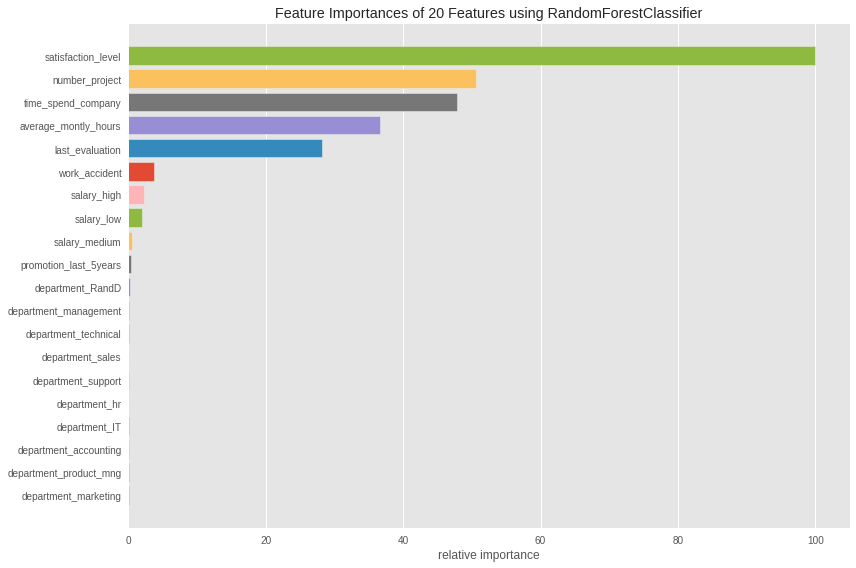

In [19]:
rf = RandomForestClassifier(bootstrap='True', ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=1,
                       verbose=False, warm_start=False)

viz = FeatureImportances(rf)
viz.fit(X_train,y_train)
viz.show()

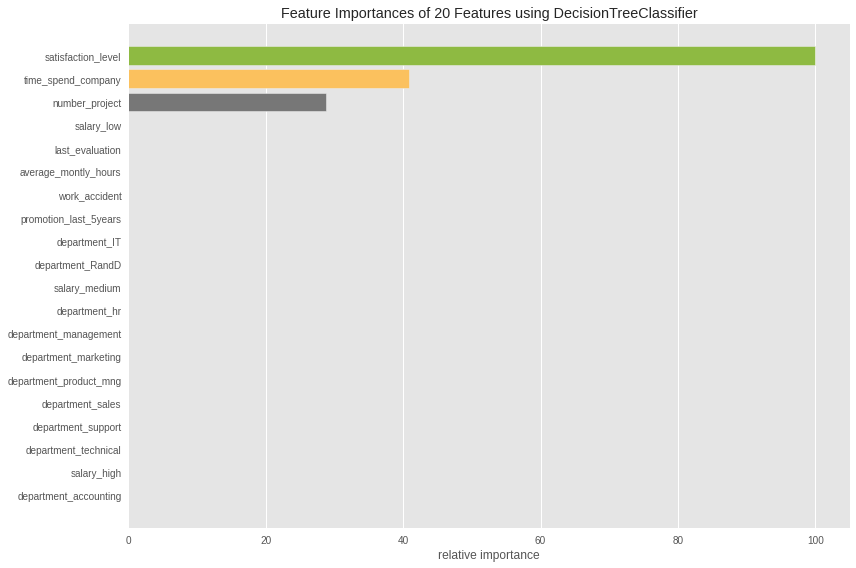

In [20]:
dt = DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=2, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')
viz = FeatureImportances(dt)
viz.fit(X_train,y_train)
viz.show()

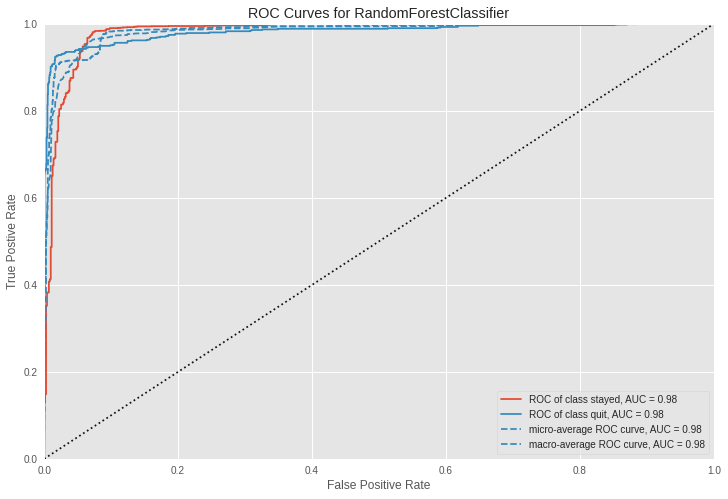

In [21]:
from yellowbrick import ROCAUC
vis = ROCAUC(rf,classes=['stayed','quit'])
vis.fit(X_train,y_train)
vis.score(X_test,y_test)
vis.show()

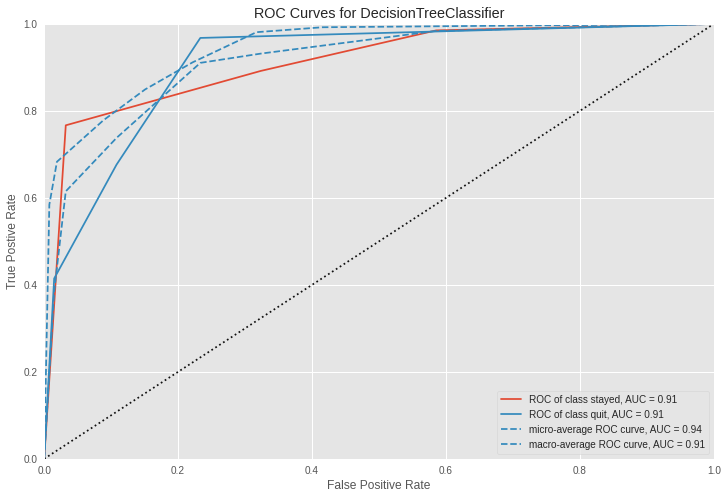

In [23]:
vis = ROCAUC(dt,classes=['stayed','quit'])
vis.fit(X_train,y_train)
vis.score(X_test,y_test)
vis.show()